[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ibrahim-ince/BrainTumorClassification/blob/main/15_Classes/F15_25.ipynb)

In [ ]:
!pip install tensorflow==2.9.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.9.0


In [ ]:
!mkdir data
!unzip "/content/drive/MyDrive/TumorSiniflandirma/archive.zip" -d "/content/data/"

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os
import cv2
import albumentations as A
import shutil

from keras import regularizers
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, Activation, Add, GlobalAveragePooling2D, MaxPooling2D, Input, Flatten
from keras.regularizers import l1_l2
from keras.models import Model
from keras.optimizers import Adam, Adamax, Nadam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/TumorSiniflandirma/train.csv")
valid_df = pd.read_csv("/content/drive/MyDrive/TumorSiniflandirma/valid.csv")
test_df = pd.read_csv("/content/drive/MyDrive/TumorSiniflandirma/test.csv")

In [ ]:
def to15(df):
    image_paths = []
    labels = []
    for path, label in zip(df['image_path'], df['label']):
        image_paths.append(path)
        labels.append(label.split(" ")[0])
    pd_df = pd.DataFrame({
        'image_path' : image_paths,
        'label' : labels
    })
    return pd_df

In [ ]:
train_df = to15(train_df)
valid_df = to15(valid_df)
test_df = to15(test_df)

In [ ]:
def count_plot(x, title, xlabel, ylabel, width, length, order = None, rotation=False, palette='winter'):
    plt.figure(figsize=(width,length))
    sns.countplot(x = x, palette=palette, order = order)
    plt.title(title, fontsize=25)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

In [ ]:
img_size = (224, 224)
channels = 3
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size = 16

test_length = len(test_df)
test_batch_size = sorted([int(test_length / n) for n in range(1, test_length + 1) if test_length % n == 0 and test_length / n <= 80], reverse=True)[0]  
test_steps = int(test_length / test_batch_size)   

In [ ]:
train_gen = ImageDataGenerator()

test_gen = ImageDataGenerator()

train_gen = train_gen.flow_from_dataframe(train_df, 
                                    x_col= 'image_path', 
                                    y_col= 'label', 
                                    target_size= img_size, 
                                    class_mode= 'categorical',
                                    color_mode= color, 
                                    shuffle= True, 
                                    batch_size= batch_size)

valid_gen = test_gen.flow_from_dataframe(valid_df, 
                                    x_col= 'image_path', 
                                    y_col= 'label', 
                                    target_size= img_size, 
                                    class_mode= 'categorical',
                                    color_mode= color, 
                                    shuffle= False, 
                                    batch_size= batch_size)

test_gen = test_gen.flow_from_dataframe(test_df, 
                                   x_col= 'image_path', 
                                   y_col= 'label', 
                                   target_size= img_size, 
                                   class_mode= 'categorical',
                                   color_mode= color, 
                                   shuffle= False, 
                                   batch_size= test_batch_size)

Found 3134 validated image filenames belonging to 15 classes.
Found 672 validated image filenames belonging to 15 classes.
Found 672 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [ ]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen) # get a sample batch from the generator 
    plt.figure(figsize = (25, 25))
    length = len(labels)
    if length < 25:   #show maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

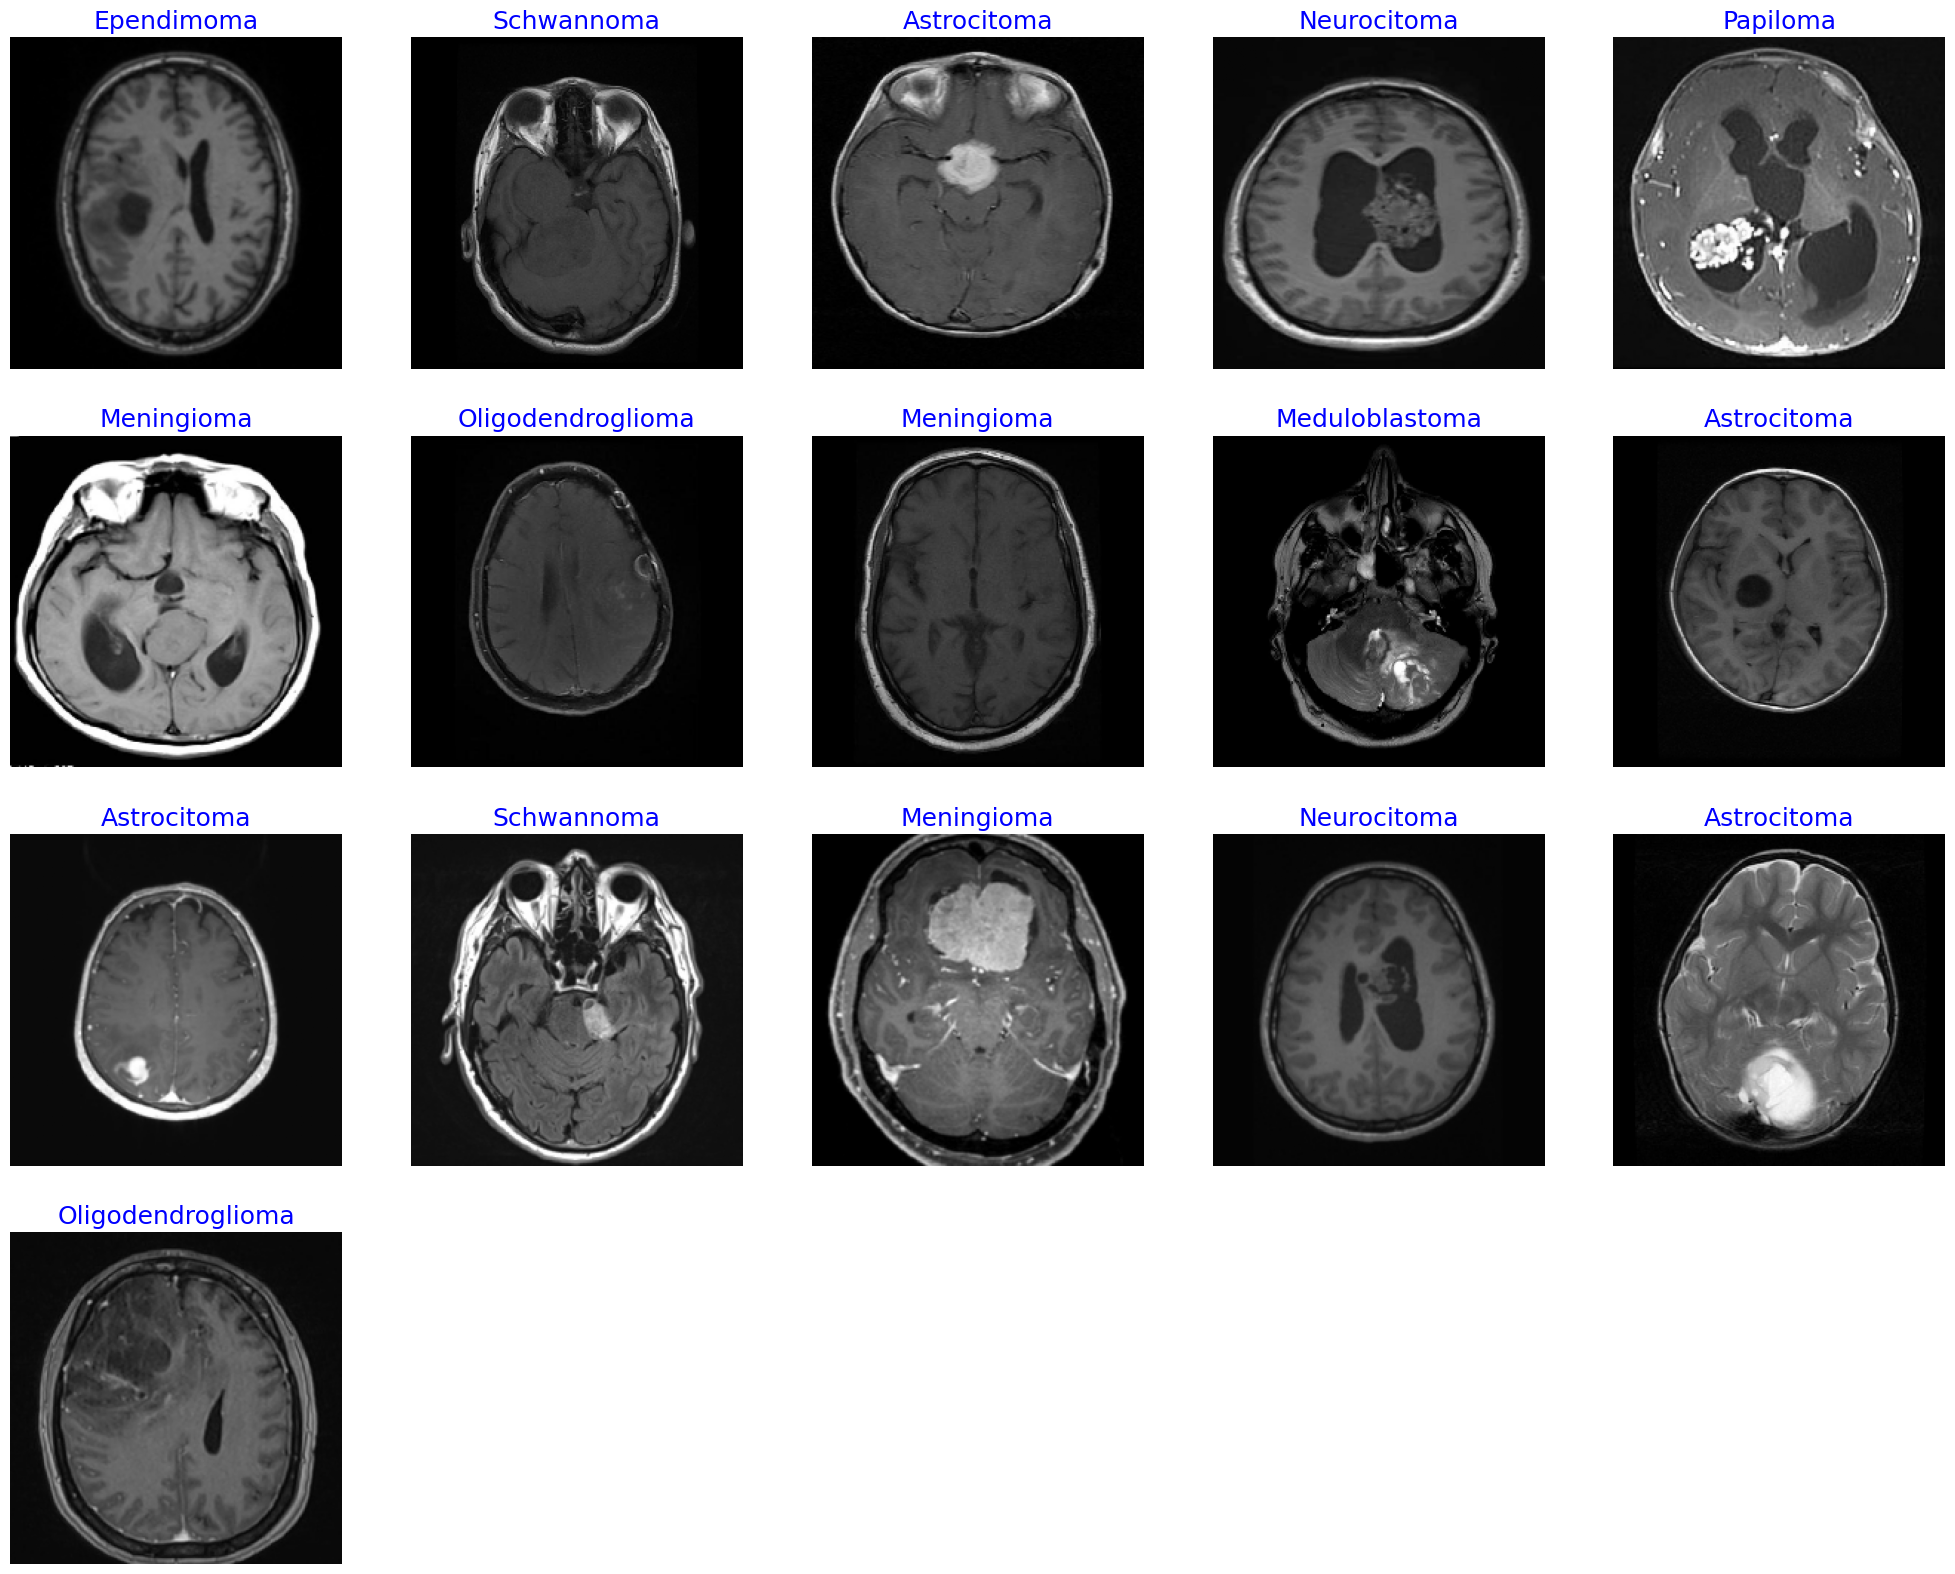

In [ ]:
show_image_samples(train_gen)

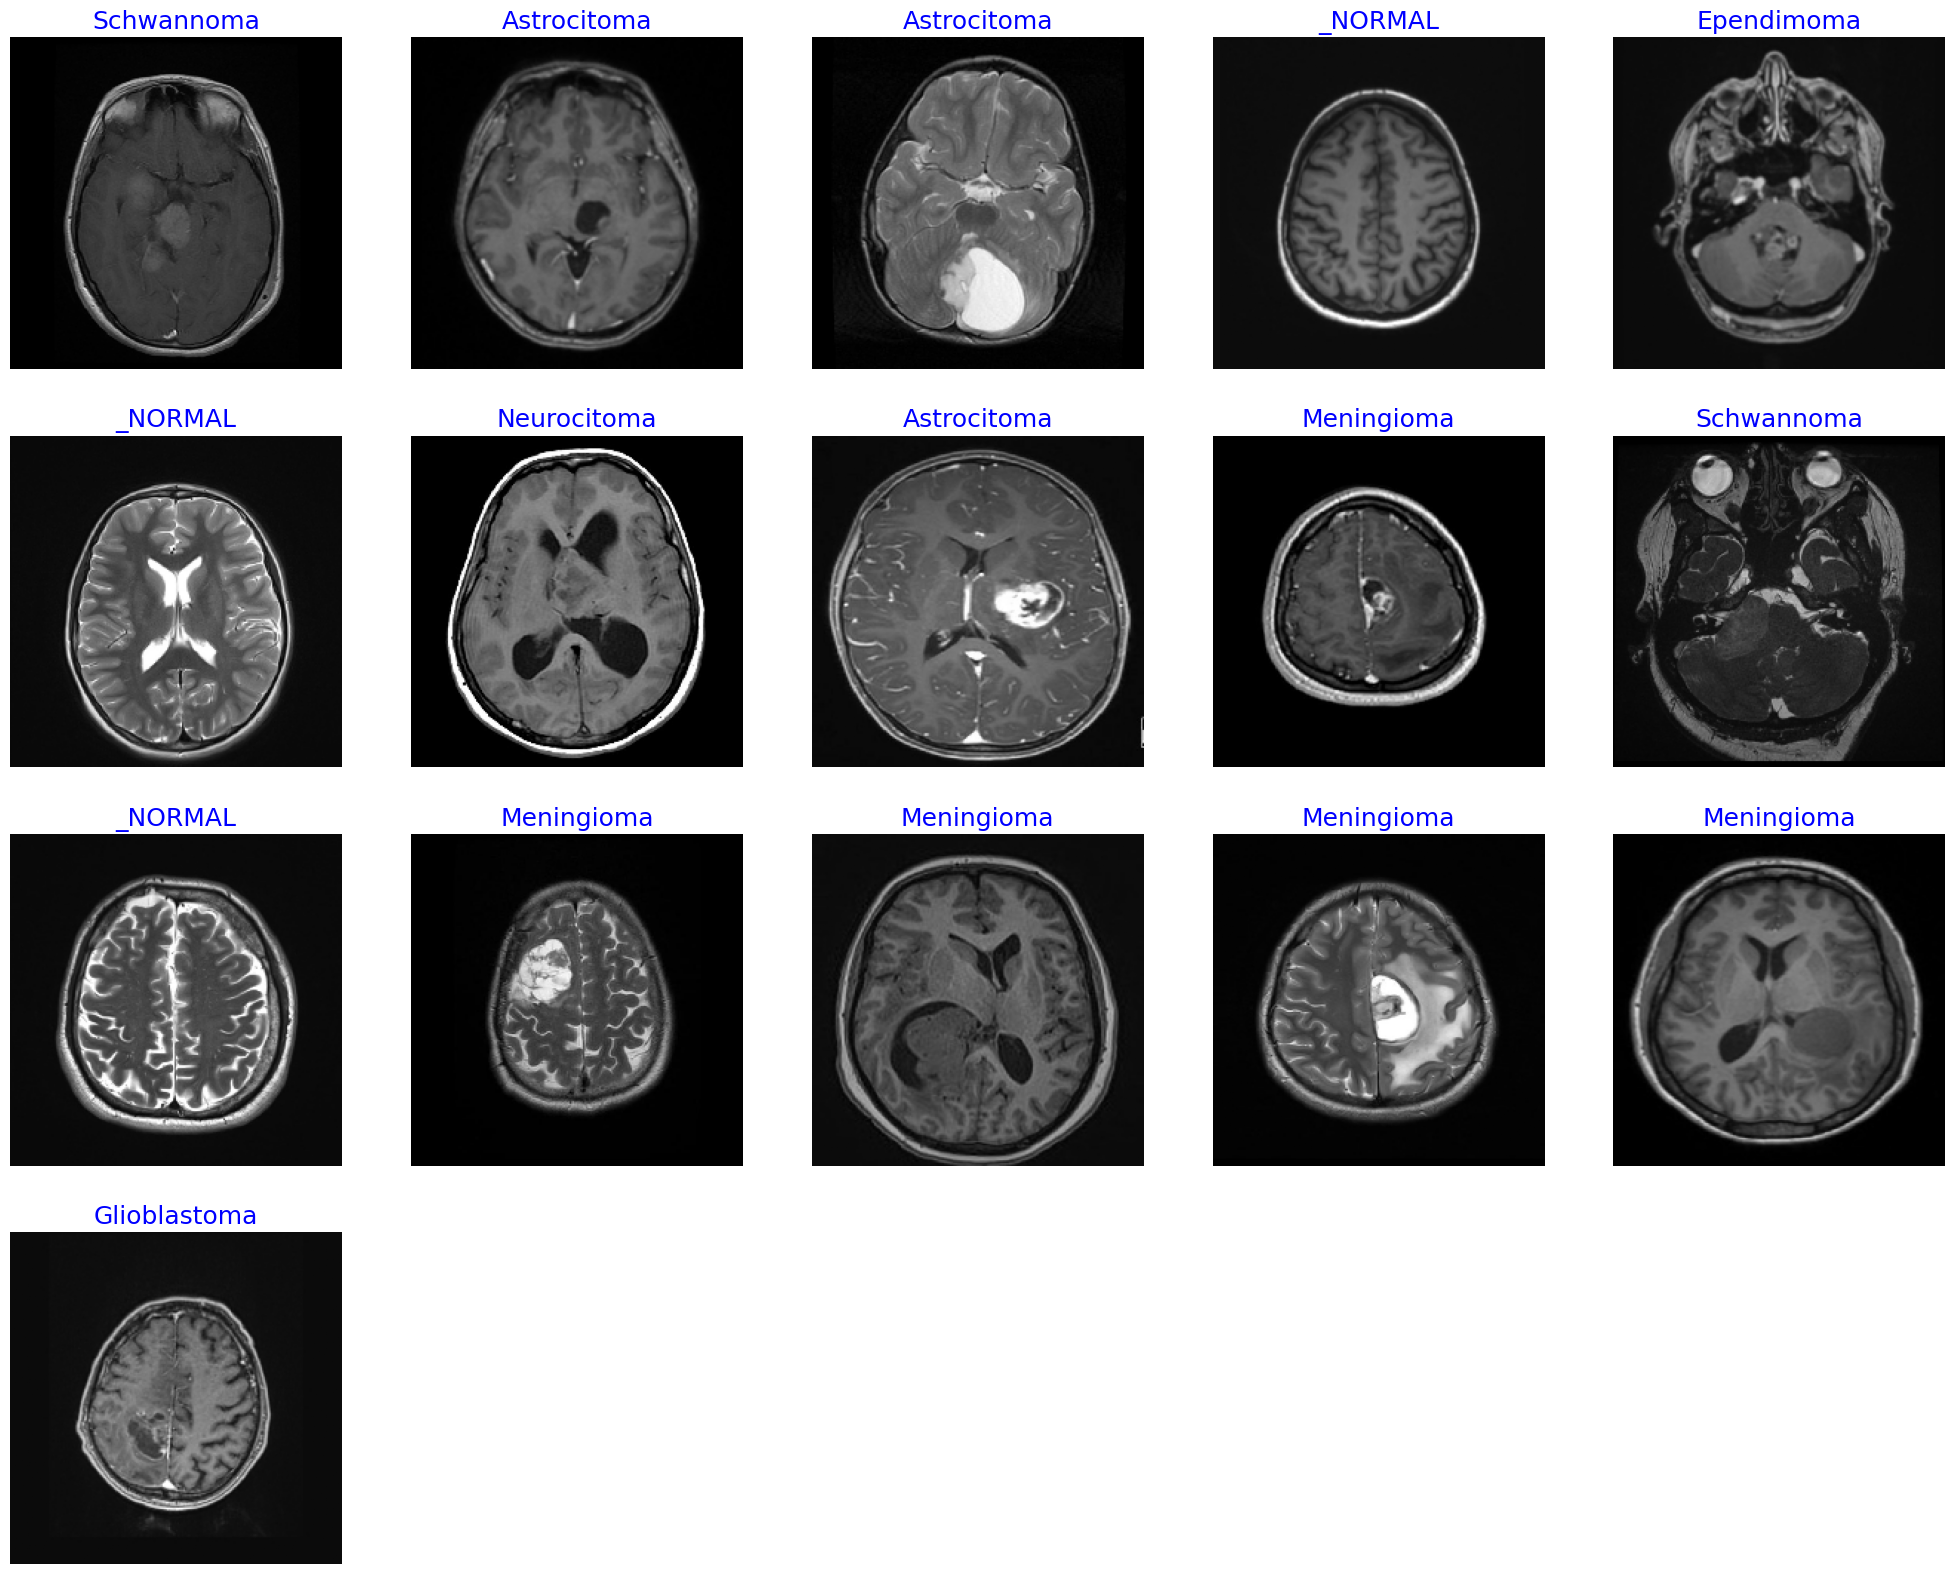

In [ ]:
show_image_samples(valid_gen)

In [ ]:
show_image_samples(test_gen)

In [ ]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# this is the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return

def predictor(model,test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    cm = confusion_matrix(ytrue, ypred )
    # plot the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

def print_errors(error_list,error_pred_list, delimiter):
    if len(error_list) == 0:
        print('There were no errors in predicting the test set')
    else:
        if len(error_list)>500:
            print('There were over 50 misclassifications, the error list will not be printed')
        else:
            print('Below is a list of test files that were miss classified \n')
            print('{0:^50s}{1:^50s}'.format('Test File', ' Predicted as'))            
            for i in range(len(error_list)):
                fpath=error_list[i]                
                split=fpath.split(delimiter)                 
                slength=len(split)
                f=split[slength-2].split(" ")[0]   
                print(f'{f:^50s}{error_pred_list[i]:^50s}')

def plot_errors_vs_class(error_list, delimiter):
    if len(error_list)==0:
        return 
    error_classes=[]
    for i in range(len(error_list)):
                fpath=error_list[i]                
                split=fpath.split(delimiter)
                slength=len(split)                
                klass= split[slength-2].split(" ")[0]                
                if klass not in error_classes:
                    error_classes.append(klass)   
    error_classes=sorted(error_classes, reverse=True)    
    error_count= [0 for i in range(len(error_classes))]
    for  i in range (len(error_classes)):
        eklass=error_classes[i]    
        for fpath in error_list:
            split=fpath.split(delimiter)
            slength=len(split)
            fklass= split[slength-2].split(" ")[0]
            if eklass == fklass:
                error_count[i] +=1
    fig=plt.figure()
    L=len(error_classes)
    if (L)<= 10:
        fig.set_figheight(L)
    elif L >10 and  L <=20:
        fig.set_figheight(int(len(error_classes)/2))
    else:
        fig.set_figheight(int(len(error_classes)/2.5))
    fig.set_figwidth(12)
    plt.style.use('fivethirtyeight')
    plt.barh(error_classes, error_count)
    plt.title( ' Classification Errors on Test Set by Class')
    plt.show()
    return error_classes, error_count

def print_error_rate(error_classes, error_count, test_df):
    value_counts = []
    for i in range(len(error_classes)):
         value_counts.append((test_df['label'].values == error_classes[i]).sum())
    error_rates = [0 for i in range(len(error_classes))]
    for i in range(len(error_classes)):
        error_rates[i] = (error_count[i] / value_counts[i]) * 100
    fig=plt.figure()
    L=len(error_classes)
    if (L)<= 10:
        fig.set_figheight(L)
    elif L >10 and  L <=20:
        fig.set_figheight(int(len(error_classes)/2))
    else:
        fig.set_figheight(int(len(error_classes)/2.5))
    fig.set_figwidth(12)
    plt.style.use('fivethirtyeight')
    plt.barh(error_classes, error_rates)
    plt.title( ' Classification Error Rates on Test Set by Class')
    plt.show()

In [ ]:
class_count = len(list(train_gen.class_indices.keys()))

In [ ]:
def create_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # initial convolutional layer
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # ResNet blocks
    num_filters = 64
    num_blocks_list = [2, 2, 2, 2]
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            # first block in a group
            if j == 0:
                strides = 2
                y = Conv2D(filters=num_filters, kernel_size=(3, 3), strides=(strides, strides), padding='same')(x)
                y = BatchNormalization()(y)
                y = Activation('relu')(y)
                
                # shortcut connection
                shortcut = Conv2D(filters=num_filters, kernel_size=(1, 1), strides=(strides, strides), padding='valid')(x)
                shortcut = BatchNormalization()(shortcut)
                
                x = Add()([y, shortcut])
                x = Activation('relu')(x)
                
            # remaining blocks in a group
            else:
                y = Conv2D(filters=num_filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
                y = BatchNormalization()(y)
                y = Activation('relu')(y)
                
                x = Add()([y, x])
                x = Activation('relu')(x)
        
        num_filters *= 2
        
    # final layers
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer = regularizers.l1(0.006), bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
    x = Dropout(rate = 0.4, seed = 123)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [ ]:
model = create_resnet(img_shape, class_count)

model.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy', F1_score, 'AUC'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
save_path = "/content/drive/MyDrive/TumorSiniflandirma/final_models/F15_25.h5"

In [ ]:
checkpoint = ModelCheckpoint(save_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='min', 
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5,
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              mode='auto',
                              min_lr=0.0001,
                              verbose= 1)

history = model.fit(x= train_gen, 
                    epochs= 100, batch_size= 16,
                    callbacks=[early_stop, checkpoint, reduce_lr],
                    validation_data= valid_gen)

Epoch 1/100
196/196 [==============================] - ETA: 0s - loss: 7.1760 - accuracy: 0.4509 - F1_score: 0.3098 - auc: 0.8458
Epoch 1: val_loss improved from inf to 7.05087, saving model to /content/drive/MyDrive/TumorSiniflandirma/final_models/F15_25.h5
196/196 [==============================] - 35s 117ms/step - loss: 7.1760 - accuracy: 0.4509 - F1_score: 0.3098 - auc: 0.8458 - val_loss: 7.0509 - val_accuracy: 0.4211 - val_F1_score: 0.2343 - val_auc: 0.8112 - lr: 0.0010
Epoch 2/100
196/196 [==============================] - ETA: 0s - loss: 5.1637 - accuracy: 0.7406 - F1_score: 0.6913 - auc: 0.9674
Epoch 2: val_loss improved from 7.05087 to 4.74910, saving model to /content/drive/MyDrive/TumorSiniflandirma/final_models/F15_25.h5
196/196 [==============================] - 22s 112ms/step - loss: 5.1637 - accuracy: 0.7406 - F1_score: 0.6913 - auc: 0.9674 - val_loss: 4.7491 - val_accuracy: 0.7381 - val_F1_score: 0.6784 - val_auc: 0.9725 - lr: 0.0010
Epoch 3/100
196/196 [===============

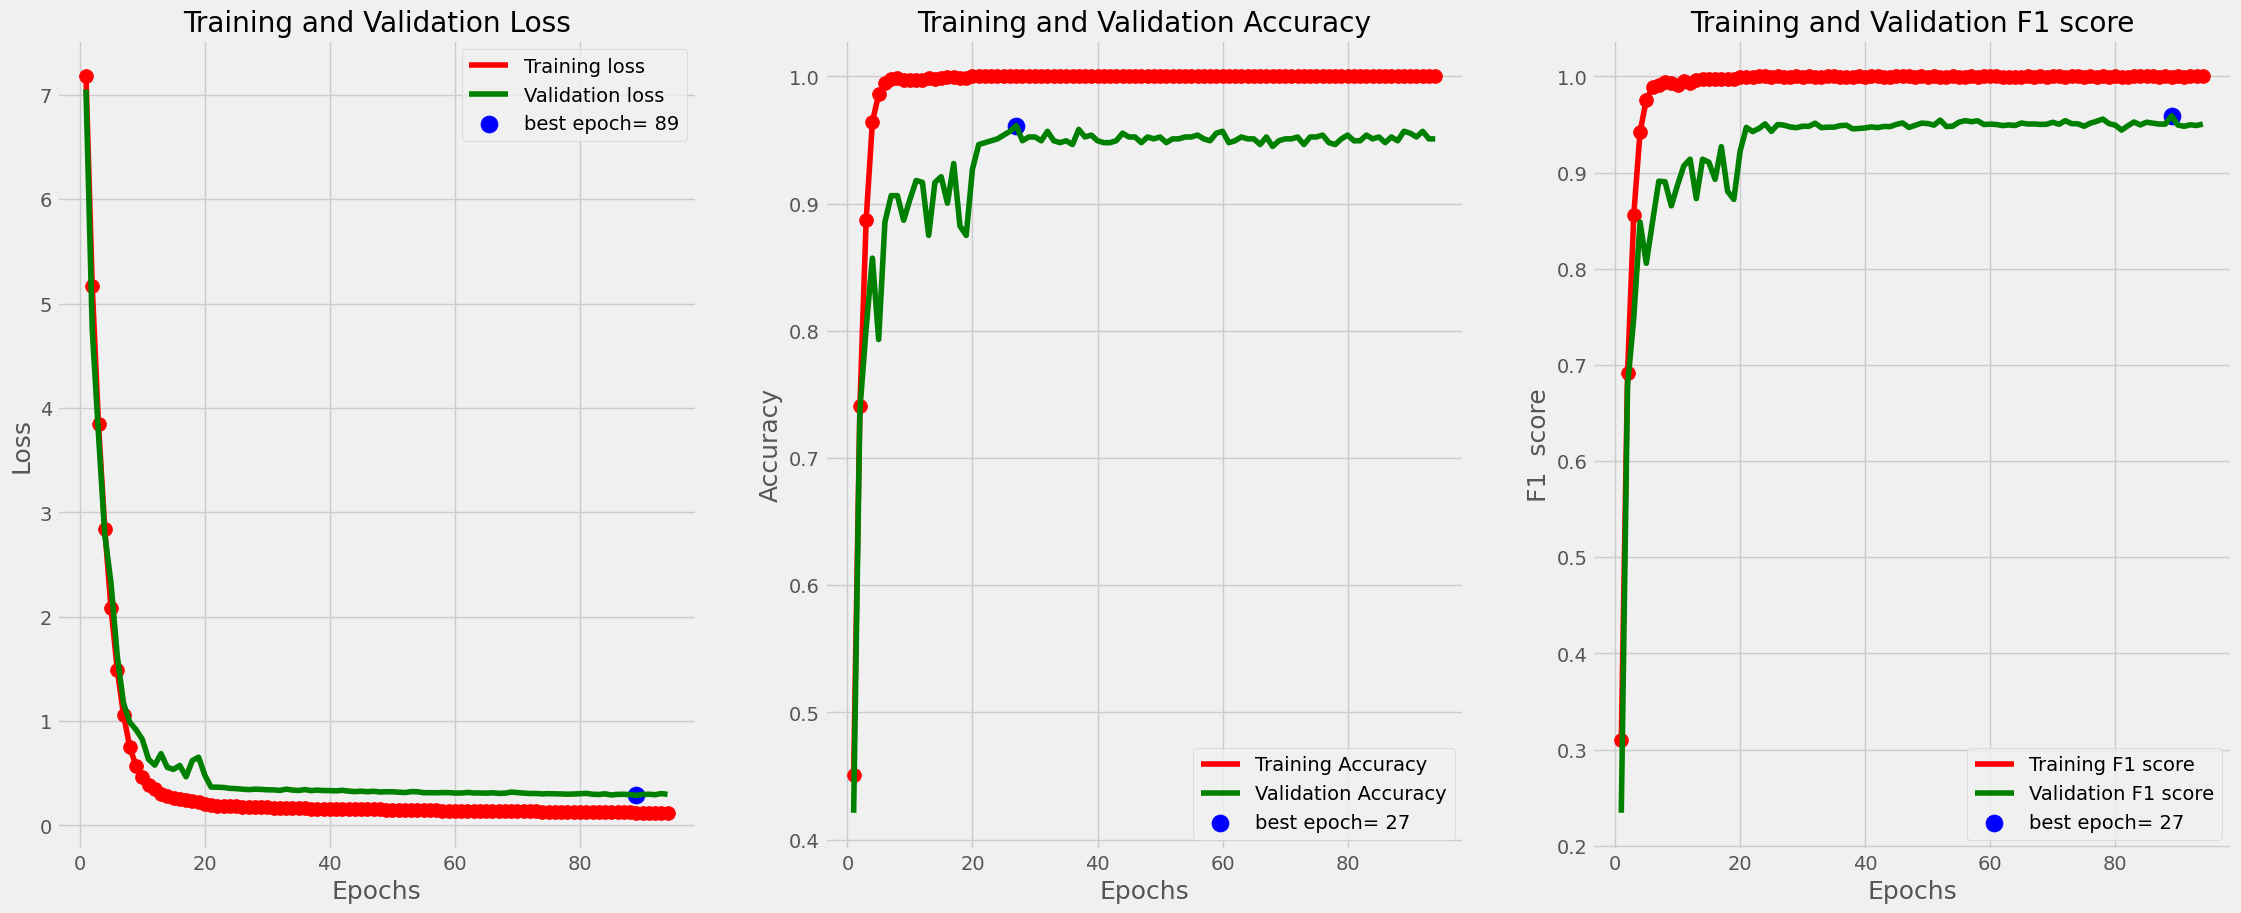

In [ ]:
tr_plot(history)

In [ ]:
best_model = tf.keras.models.load_model(save_path, custom_objects={"F1_score": F1_score})

In [ ]:
train_score = best_model.evaluate(train_gen, verbose= 1)
valid_score = best_model.evaluate(valid_gen, verbose= 1)
test_score = best_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train F1-score: ", train_score[2])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("Validation F1-score: ", valid_score[2])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test F1-score: ", test_score[2])

12/12 [==============================] - 4s 308ms/step - loss: 0.3356 - accuracy: 0.9315 - F1_score: 0.9405 - auc: 0.9964
Train Loss:  0.11414235085248947
Train Accuracy:  1.0
Train F1-score:  1.0
--------------------
Validation Loss:  0.2879289984703064
Validation Accuracy:  0.956845223903656
Validation F1-score:  0.9590041637420654
--------------------
Test Loss:  0.33557629585266113
Test Accuracy:  0.9315476417541504
Test F1-score:  0.9405043721199036


12/12 [==============================] - 4s 293ms/step
there were 46 errors in 672 tests for an accuracy of  93.15


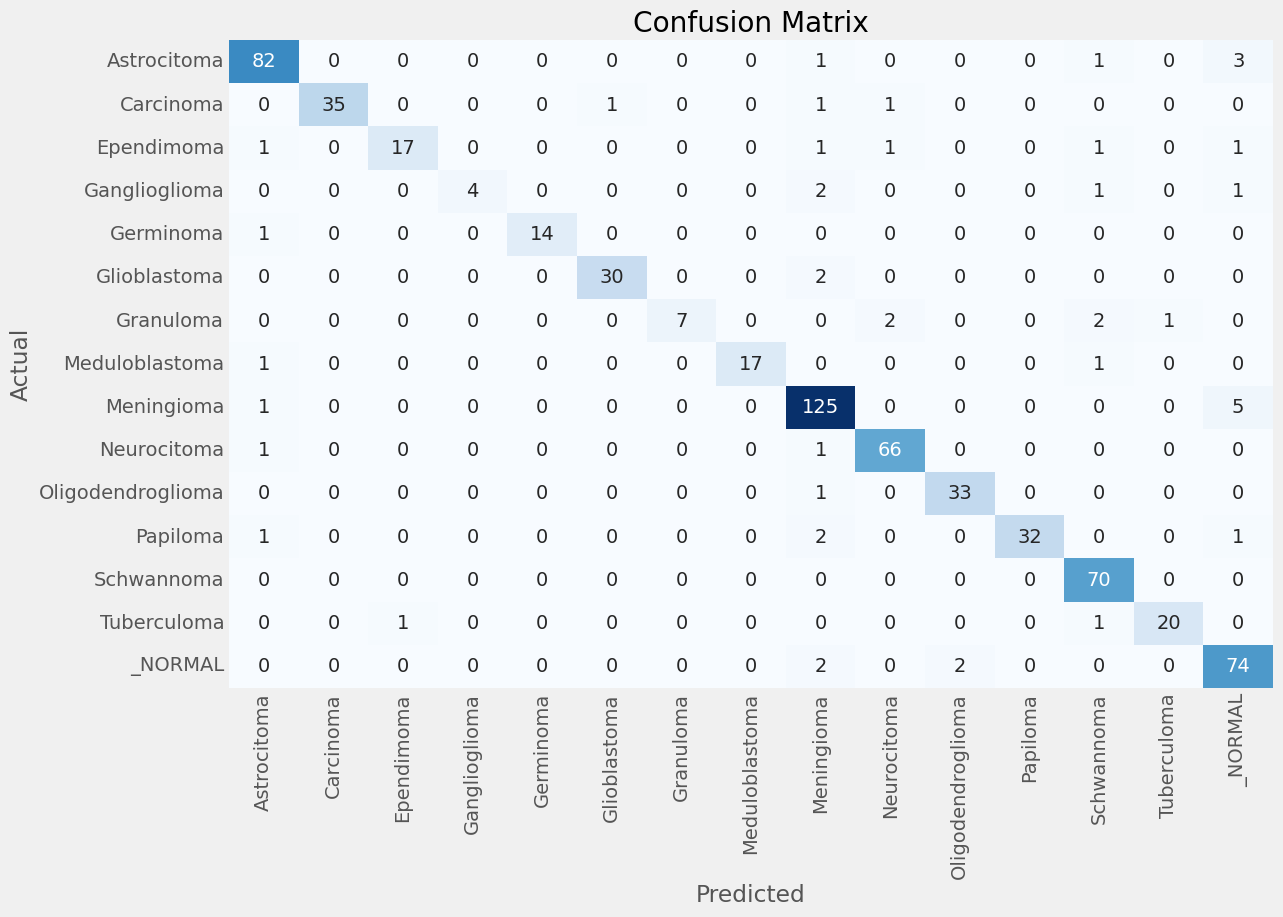

Classification Report:
----------------------
                    precision    recall  f1-score   support

      Astrocitoma     0.9318    0.9425    0.9371        87
        Carcinoma     1.0000    0.9211    0.9589        38
       Ependimoma     0.9444    0.7727    0.8500        22
    Ganglioglioma     1.0000    0.5000    0.6667         8
        Germinoma     1.0000    0.9333    0.9655        15
     Glioblastoma     0.9677    0.9375    0.9524        32
        Granuloma     1.0000    0.5833    0.7368        12
   Meduloblastoma     1.0000    0.8947    0.9444        19
       Meningioma     0.9058    0.9542    0.9294       131
      Neurocitoma     0.9429    0.9706    0.9565        68
Oligodendroglioma     0.9429    0.9706    0.9565        34
         Papiloma     1.0000    0.8889    0.9412        36
       Schwannoma     0.9091    1.0000    0.9524        70
      Tuberculoma     0.9524    0.9091    0.9302        22
          _NORMAL     0.8706    0.9487    0.9080        78

       

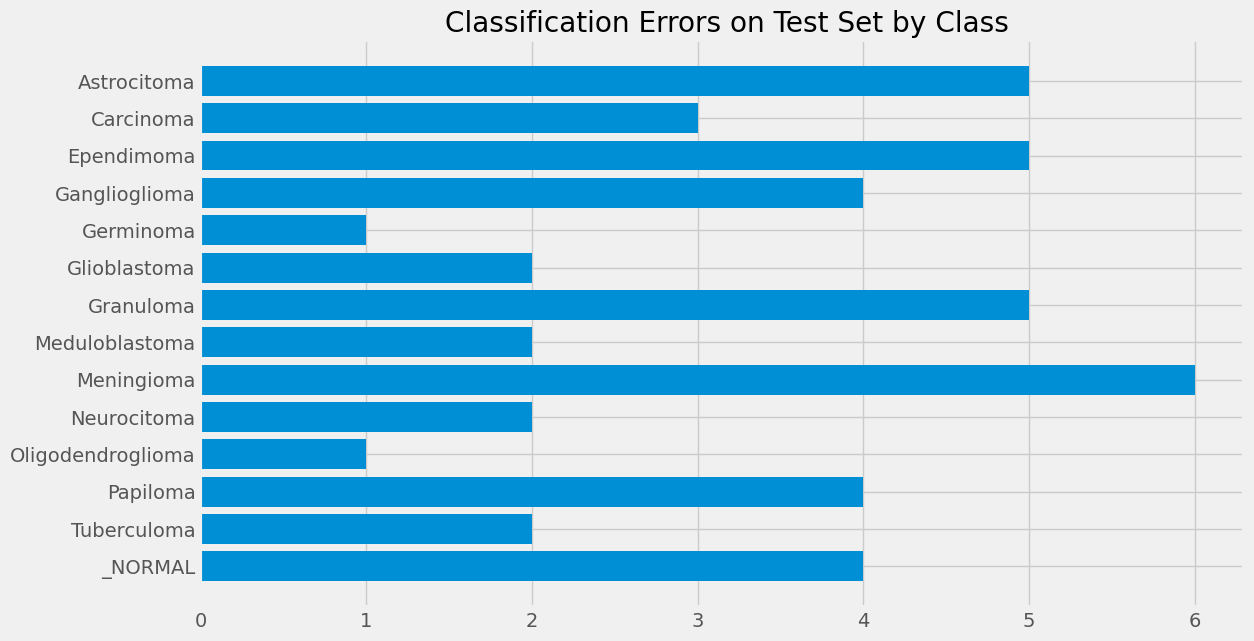

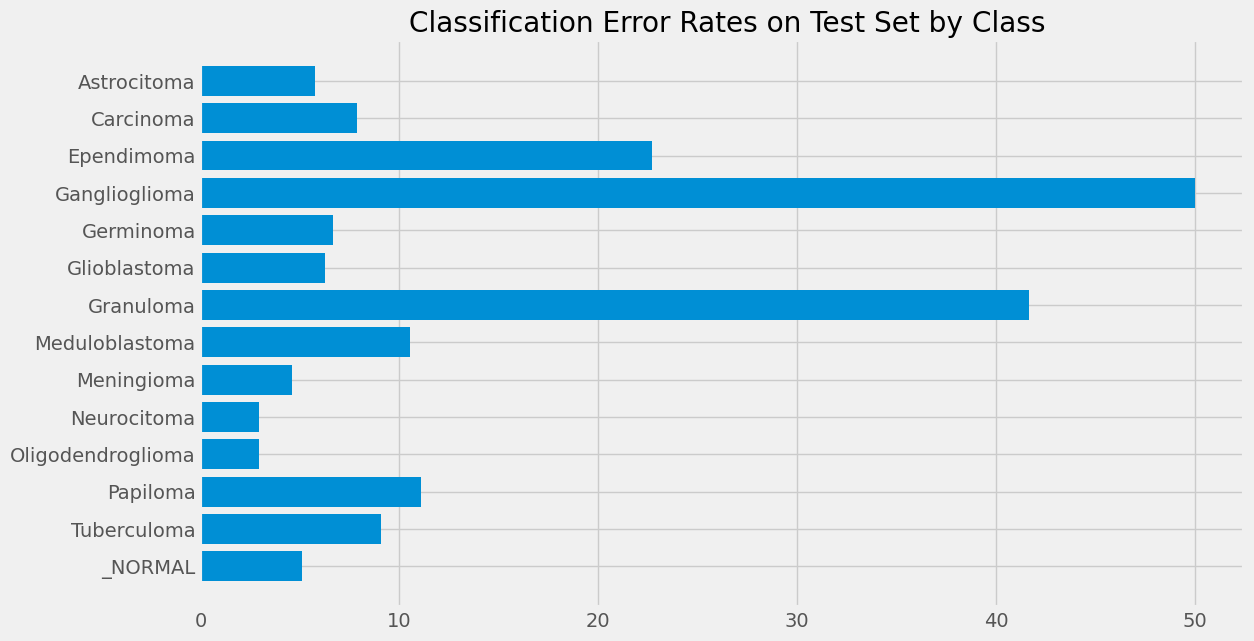

In [ ]:
delimiter = '/'
errors, tests, error_list, error_pred_list, f1score = predictor(best_model, test_gen)
print_errors(error_list, error_pred_list, delimiter)
error_classes, error_count = plot_errors_vs_class(error_list, delimiter)
print_error_rate(error_classes, error_count, test_df)